# RV calculation at Observation Times.

To determine the expected RV shifts of the spectral lines seen my stellar subracted spectra.

In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

from PyAstronomy import pyasl   # for doppler shift
import sys
#sys.path.append('/home/jneal/azores/planet/rvs/exonailer/utilities')
try: 
    #import ajplanet
    from ajplanet import pl_rv_array
except:
    pass
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Rodrigo Diaz's true anomaly calculation
def trueanomaly(ma, ecc, niterationmax=10000):
    """
    Compute the true anomaly using the Newton-Raphson method.

    :param array-like ma: mean anomaly.
    :param float ecc: orbital eccentricity.
    :param int niterationmax: maximum number of iterations for N-R method.
    """
    
    if not isinstance(ma, float):
        ea = ma
    else:
        ea = np.array([ma,])

    # Initialise at ea0 = ma
    niteration = 0
    ea0 = ma
    
    while np.linalg.norm(ea - ea0, ord=1) > 1e-5 or niteration==0:
        ea0 = ea
 
        ff = ea - ecc*np.sin(ea) - ma   # Function
        dff = 1 - ecc*np.cos(ea)        # Derivative

        # Use Newton method
        ea = ea0 - ff / dff

        # Increase iteration number; if above limit, break with exception.
        niteration += 1
        if niteration >= niterationmax:
            raise RuntimeError('Eccentric anomaly computation'
                               'not converged.')
        
    # Compute true anomaly from eccentric anomaly
    return 2. * np.arctan2(np.sqrt(1. + ecc) * np.sin(ea/2.),
                           np.sqrt(1. - ecc) * np.cos(ea/2.))

# Mean Anomaly calculation
def meananomaly(t, T0, P):
    """ Calculate mean Anomaly using period, tau and a time value"""
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    return 2 * np.pi * (t - T0) / P

# Basic RV calculation
def radialvelocity(gamma, K, ta, omega, ecc):
    # Calculate radial velocity of star
    return gamma + K *(np.cos(ta + omega) + ecc * np.cos(omega))

# RV calculation done in python (for when ajplanet is not available)
def rv_curve_py(t, gamma, K, omega, ecc, T, P):
    ma = meananomaly(t, T, P)
    ta = trueanomaly(ma, ecc)
    rv = radialvelocity(gamma, K, ta, omega, ecc)
    return rv
        

In [4]:
#Silly epoch of T0 in a paper of 1997.04 +- 0.02 . need to turn into julian days
#Crepp 2016 updated HD4747 parameters  t = 1997.04
#print(0.04 * 365)
#print(.6*24)
#print(.4*60)
# Julian date for CE  1997 January 14 14:24:00.0 UT is JD 2450463.100000

# Orbtial Parameters and epochs.

In [5]:
Msun_Mjup = 1047.56 # Mjup

#Target parameters:  Obtained from sahlmann et al. 

#HD4747_params   = [9.904, 703.3, -94.2, 0.723, 62059.1, 11593.2] # Best fit solution from sahlmann not complete period coverage
#Crepp 2016 updated HD4747 parameters  t = 1997.04
#                 [mean_val, K1, omega,   e,     Tau,       Period, starmass (Msun), msini(Mjup), i] 
d = 365.25  # Days in a year
HD4747_params   = [-0.219,  .7553,  -269.1, 0.740,  50463.10,  13826.2, 0.81, 46.1]  # turn 37.88 years into days
HD162020_params = [-27.328,  1.813,  28.40, 0.277, 51990.677, 8.428198, 0.74, 14.4]  # here mean val in km/s K in m/s https://arxiv.org/pdf/astro-ph/0202458v2.pdf
HD167665_params = [8.003,   .6095, -134.3, 0.340,   56987.6,   4451.8, 1.14, 50.6]  # sahlman
HD211847_params = [6.689,   .2914,  159.2, 0.685,   62030.1,   7929.4, 0.94, 155]  # Best fit solution from sahlmann not complete period coverage
HD30501_params =  [23.710, 1.7031,   70.4, 0.741,   53851.5,   2073.6, 0.81, 90]  # sahlman

# 2 companions
# One of these used 3 body equations - need to compare relative strengths
HD168443b_params = [-0.046533, .475133, 172.923, 0.52883, 55626.199, 58.1125, 0.995, 7.659] #  % msini = 7.659Mjp, a=0.2931AU, dv/dt (ms−1 yr−1) −0.00868
HD168443c_params = [-0.046533, .29770, 64.87, 0.2113, 55521.3, 1749.83, 0.995, 17.193] 
# [mean_val, K1, omega,   e,     Tau,       Period, starmass (Msun), msini(Mjup), i]
HD202206b_params = [14.721, .567, 161.9, 0.435, 52176.14, 256.33, 1.04, 93.6] #\citet{Correia2005_hd202206bc}\\  % \lambda = 266.228 deg (mean longitude)
HD202206c_params = [14.721, .041, 280, 0.22, 53103, 1260, 1.04, 17.9] # \citet{Correia2005_hd202206bc}\\ % \lambda = 30.586 deg (mean longitude)

# These were added as parameters [6] and [7]
HD30501_mass = [0.81, 90]  # actual
HD168443_massb = [0.995, 7.659]
HD168443_massc = [0.995, 17.193] # minimum i 
HD4747_mass = [0.81, 46.1]
HD167665_mass = [1.14, 50.6]  # minimum
HD211847_mass = [0.94, 19.2]
HD162020_mass = [0.74, 14.4]  # minimum
HD202206_massb = [1.04, 17.4]  # minimum
HD202206_massc = [1.04, 2.44]
#Median times 
# extremeties are +- 14 minutes
HD30501_times =  [2456024.505902, 2456140.88716, 2456141.86633, 2456145.904258]  # from data - need to double check with calculated data centers
HD162020_times = [2456112.76624, 2456112.79015]
HD202206_times = [ 2456120.78801, 2456121.73727, 2456119.85411]   
HD211847_times = [2456114.8035, 2456121.78793]  
HD4747_times =   [2456114.81674]
HD167665_times = [2456136.70895, 2456136.73434, 2456144.62087] 
HD168443_times = [2456144.68718, 2456144.70753]
params_dict = {"HD30501":HD30501_params, "HD211847":HD211847_params, \
               "HD4747":HD4747_params, "HD167665":HD167665_params, \
               "HD162020":HD162020_params, \
               "HD202206b":HD202206b_params,"HD202206c":HD202206c_params, \
               "HD168443b":HD168443b_params,"HD168443c":HD168443c_params}
               # "HD202206":HD202206_params,
    
times_dict = {"HD30501":HD30501_times, "HD162020":HD162020_times, \
              "HD202206":HD202206_times, "HD211847":HD211847_times, \
              "HD4747":HD4747_times, "HD167665":HD167665_times, \
             "HD168443":HD168443_times}


# Keplerian Orbital Parameters:

In [6]:
def RV_from_params(t, params, use_offset=True):
    """ Get RV values with parameter list.
    
    input:
        t -- The time/s at which to calculate the RV value
        params -- a list of values [mean_val, K1, omega, e, Tau, Period]
    
    omega should be given in degrees. This function converts it to radians.
    
    Outputs:
        RVs -- The radial velocity values evaluated at the given times.
    
    """
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    
    #Solar Mass conversion to MJup
    Msun_Mjup = 1047.56 # Mjup
    
    # Slice params to separate from input list and replace K for the planet
    # The other parameters are the same
    star_params = params[:]
    planet_params = params[:]  
    # Note: test that is np.deg2rad is faster than *np.pi /180
    star_params[2] = np.deg2rad(star_params[2])
    planet_params[2] = np.deg2rad(planet_params[2])
        
    if not use_offset:
        star_params[0] = 0
        planet_params[0] = 0
    else:
        star_params[0] = star_params[0] * 1000 # Turn into m/s
        planet_params[0] = planet_params[0] * 1000 # Turn into m/s
   
    # Scale K for planet
    K1 = star_params[1]
    mass_ratio = Msun_Mjup*planet_params[6] / planet_params[7]
    #print("star/planet Mass Ratio", mass_ratio)
    K2 = -mass_ratio * K1
    planet_params[1] = K2
    
    #planet_params[2] += np.pi # omeaga phase do I need to add pi### NO!
    
    try: # Try rv_curve first
        #import ajplanet
        star_rvs = pl_rv_array(t, *star_params[0:6]) # *unpacks parameters from list
        planet_rvs = pl_rv_array(t, *planet_params[0:6]) # *unpacks parameters from list
        #print("used ajplanet")
    except:
        star_rvs = rv_curve_py(t, *star_params[0:6]) # *unpacks parameters from list
        planet_rvs = rv_curve_py(t, *planet_params[0:6]) # *unpacks parameters from list
        #print("used python")
        
    return star_rvs, planet_rvs


def plot_RV_phase_curve(params, name=False, t_vals=False, use_offset=False, t_future=False):
    """Plot RV phase curve use period and T0 to get times from phase.
    
    params -- a list of values [mean_val, K1, omega, e, Tau, Period]"""
    
    phase = np.linspace(-0.1,1.1, 200)
    t = params[4] + phase * params[5]
    
    star_rvs, planet_rvs = RV_from_params(t, params, use_offset=use_offset)
    
    plt.figure()
    plt.plot(phase, star_rvs, label="Star", lw=2)
    plt.plot(phase, planet_rvs/100, label="Planet/100", lw=2)
    if name:
        plt.title("RV Phase curve for {}".format(name))
    else:
        plt.title("RV Phase curve")
    if t_vals:
        for t_num, t_val in enumerate(t_vals):
            phi = (t_val - params[4])/params[5]  % 1
            rv_star, rv_planet = RV_from_params(t_val, params, use_offset=False)
            plt.plot(phi, rv_star, ".", markersize=12, markeredgewidth=3)
            plt.plot(phi, rv_planet/100, ".", markersize=12, markeredgewidth=3)
            
    if t_future:
        for t_num, t_val in enumerate(t_future):
            phi = (t_val - params[4])/params[5]  % 1
            rv_star, rv_planet = RV_from_params(t_val, params, use_offset=False)
            plt.plot(phi, rv_star, "+", markersize=12, markeredgewidth=3)
            plt.plot(phi, rv_planet/100, "+", markersize=12, markeredgewidth=3)
    plt.legend(loc=0)
    plt.xlabel("Phase")
    plt.ylabel("RV amplitude (m/s)")
    plt.show()
    

def plot_RV_curve_section(times, params, name=False, use_offset=False):
    """Plot RV phase curve use period and T0 to get times from phase.
    
    params -- a list of values [mean_val, K1, omega, e, Tau, Period]"""
    
    time_diff = np.max(times) - np.min(times)
    dt = np.max([0.05 * time_diff, 1/24.])
    #Need to find a good choice for t span
    t = np.linspace(np.min(times)-dt, np.max(times)+dt, 100)
    #phase = np.linspace(-0.1,1.1, 100)
    #t = params[4] + phase * params[5]
    
    star_rvs, planet_rvs = RV_from_params(t, params, use_offset=use_offset)
    
    plt.figure()
    plt.plot(t, star_rvs - star_rvs[0], label="Star - {0}m/s".format(int(star_rvs[0])))
    plt.plot(t, (planet_rvs-planet_rvs[0])/100, label="(Planet-{0}m/s)/100".format(int(planet_rvs[0])))
    if name:
        plt.title("RV difference curve from t[0] for {}".format(name))
    else:
        plt.title("RV difference curve from from t[0]")
    
    obs_time_sigma = 14/(60*24)  # +-14min
    
    for t_num, t_val in enumerate(times):
            rv_star, rv_planet = RV_from_params(t_val, params, use_offset=False)
            
            t_obs = np.linspace(t_val-obs_time_sigma, t_val+obs_time_sigma, 100)
            star_obs, planet_obs = RV_from_params(t_obs, params, use_offset=False)
            
            plt.plot(t_obs, star_obs-star_rvs[0], lw=3)
            plt.plot(t_obs, (planet_obs-planet_rvs[0])/100, lw=3)
            plt.plot(t_val, rv_star-star_rvs[0], ".", markersize=12, markeredgewidth=2)
            plt.plot(t_val, (rv_planet - planet_rvs[0])/100, ".", markersize=12, markeredgewidth=2)
    plt.legend(loc=0)
    plt.xlabel("Time (JD)")
    plt.ylabel("delta RV (m/s)")
    plt.show()    

    
def test_rv_curves(t, params):
    
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    else:
        pass
    params = params[:]
    params[2] = np.deg2rad(params[2])
    params[0] = 0

    aj_rv = pl_rv_array(t, *params) # *unpacks parameters from list
    
    py_rv = rv_curve_py(t, *params)
    
    print("Ajplanet RVs = {}".format(aj_rv))
    print("Python RVs   = {}".format(py_rv))
    return None


def Obs_RV_error(t, params, name=False ):
    
    obs_time_sigma = 14/(60*24)  # +-14min
    
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    
    t_start = t - obs_time_sigma
    t_end =  t + obs_time_sigma
    
    star_rv_start, planet_rv_start = RV_from_params(t_start, params, use_offset=False)
    star_rv_end, planet_rv_end = RV_from_params(t_end, params, use_offset=False)
    
    star_diff = star_rv_end - star_rv_start 
    planet_diff = planet_rv_end - planet_rv_start
    #if name:
        #print("RV change over observation for {} m/s".format(RV_difference))
    return star_diff, planet_diff


def RV_calculations(times, params, use_offset=False):
    Msun_Mjup = 1047.56 # Mjup
    planet_rvs = dict()    # to store some results
    
    for target in times:
        print("\nTarget {}".format(target))
        target_time = times[target]
        
        if target in ["HD202206", "HD168443"]:
            targetb = target + "b" 
            targetc = target + "c"
            target_paramb = params[targetb]
            target_paramc = params[targetc]
            
            star_rv_values, planet_rv_values = RV_from_params(target_time, target_paramb, use_offset=use_offset)
            star_rv_values_c, planet_rv_values_c = RV_from_params(target_time, target_paramc, use_offset=use_offset)
            star_rv_diff_b, planet_rv_diff_b = Obs_RV_error(target_time, target_paramb, name=targetb)
            star_rv_diff_c, planet_rv_diff_c = Obs_RV_error(target_time, target_paramc, name=targetc)
            print("Radial velocity values of the host star.")
            print("Gamma subtracted RV values for b = {0} m/s".format(star_rv_values))
            print("RV change over exptime for b     = {0} m/s".format(star_rv_diff_b))
            print("Gamma subtracted RV values for c = {0} m/s".format(star_rv_values_c))
            print("RV change over exptime for c     = {0} m/s".format(star_rv_diff_c))
            print("Combined RV value for triplet    = {0} m/s".format(star_rv_values + star_rv_values_c))
            print("Combined RV Diff between Obs     = {0} m/s".format(np.diff(star_rv_values + star_rv_values_c)))
            
            print("\nRadial velocity values of the planet.")
            print("Maximum mass ratio value for b   = {0} ".format(Msun_Mjup*target_paramb[6]/target_paramb[7]))
            print("Maximum mass ratio value for c   = {0} ".format(Msun_Mjup*target_paramc[6]/target_paramc[7]))
            print("Gamma subtracted RV values for b = {0} m/s".format(planet_rv_values))
            print("RV change over exptime for b     = {0} m/s".format(planet_rv_diff_b))
            print("Gamma subtracted RV values for c = {0} m/s".format(planet_rv_values_c))
            print("RV change over exptime for c     = {0} m/s".format(planet_rv_diff_c))
            print("Combined RV value for triplet    = {0} m/s".format(planet_rv_values + planet_rv_values_c))
            print("Combined RV Diff between Obs     = {0} m/s".format(np.diff(planet_rv_values + planet_rv_values_c)))
            
            star_successive_diff = np.diff(star_rv_values)
            print("Successive Star RV Diff of b            = {0} m/s".format(star_successive_diff))
            planet_successive_diff = np.diff(planet_rv_values)
            print("Successive planet RV Diff of b          = {0} m/s".format(planet_successive_diff))
            
            star_low_doppler, star_high_doppler = band_doppler_shifts(np.abs(star_successive_diff))
            print("Band Lower wl shift of b - star         = {} nm".format(star_low_doppler))
            print("Band Upper wl shift of b - star         = {} nm".format(star_high_doppler))
            planet_low_doppler,  planet_high_doppler = band_doppler_shifts(np.abs(planet_successive_diff))
            print("Band Lower wl shift of b - planet       = {} nm".format(planet_low_doppler))
            print("Band Upper wl shift of b - planet       = {} nm".format(planet_high_doppler))
            
            star_successive_diff_c = np.diff(star_rv_values_c)
            print("Successive Star RV Diff of c            = {0} m/s".format(star_successive_diff_c))
            planet_successive_diff_c = np.diff(planet_rv_values_c)
            print("Successive planet RV Diff of c          = {0} m/s".format(planet_successive_diff_c))
            
            star_low_doppler_c, star_high_doppler_c = band_doppler_shifts(np.abs(star_successive_diff_c))
            print("Band Lower wl shift of c - star         = {} nm".format(star_low_doppler_c))
            print("Band Upper wl shift of c - star         = {} nm".format(star_high_doppler_c))
            planet_low_doppler_c,  planet_high_doppler_c = band_doppler_shifts(np.abs(planet_successive_diff_c))
            print("Band Lower wl shift of c - planet       = {} nm".format(planet_low_doppler_c))
            print("Band Upper wl shift of c - planet       = {} nm".format(planet_high_doppler_c))
            
            
            plot_RV_phase_curve(target_paramb, name=targetb, t_vals=target_time, use_offset=False)
            plot_RV_phase_curve(target_paramc, name=targetc, t_vals=target_time, use_offset=False)
            
            plot_RV_curve_section(target_time, target_paramb, name=targetb, use_offset=False)
            plot_RV_curve_section(target_time, target_paramc, name=targetc, use_offset=False)
            
            # Fill in result dict
            #result_Dict[target+"_star_rvs"] = star_rv_values
            #result_Dict[target+"c_star_rvs"] = star_rv_valuesc
            #planet_rv_values_c
            planet_rvs[targetb] = planet_rv_values 
            planet_rvs[targetc] = planet_rv_values_c
            #result_Dict[target+"c_planet_rvs"] = planet_rv_values c
            #result_Dict[target+"_delta_wl"] = planet_low_doppler
            #result_Dict[target+"c_delta_wl"] = planet_low_dopplerc
            
        else:
            target_param = params[target]   
                                
            star_rv_values, planet_rv_values = RV_from_params(target_time, target_param, use_offset=use_offset)
            star_rv_diff, planet_rv_diff = Obs_RV_error(target_time, target_param, name=target)
            print("Radial velocity values of the host star only currently.")
            
            print("Gamma subtracted rv values = {0} m/s".format(star_rv_values))
            print("RV change over exptime     = {0} m/s".format(star_rv_diff))
            
            print("Radial velocity values of the Planet.")
            print("Maximum mass ratio value   = {0} ".format(Msun_Mjup*target_param[6]/target_param[7]))
            print("Gamma subtracted rv values = {0} m/s".format(planet_rv_values))
            print("RV change over exptime     = {0} m/s".format(planet_rv_diff))
            
            # Differences in RV between successive observations
            star_successive_diff = np.diff(star_rv_values)
            print("Successive Star RV Diff - star     = {0} m/s".format(star_successive_diff))
            planet_successive_diff = np.diff(planet_rv_values)
            print("Successive planet RV Diff - planet = {0} m/s".format(planet_successive_diff))
            
            star_low_doppler, star_high_doppler = band_doppler_shifts(np.abs(star_successive_diff))
            print("Band Lower wl shift - star         = {} nm".format(star_low_doppler))
            print("Band Upper wl shift - star         = {} nm".format(star_high_doppler))
            planet_low_doppler,  planet_high_doppler = band_doppler_shifts(np.abs(planet_successive_diff))
            print("Band Lower wl shift - planet       = {} nm".format(planet_low_doppler))
            print("Band Upper wl shift - planet       = {} nm".format(planet_high_doppler))
            
            
            #print("\n\nTesting Values\n")
            #print("planet/Star rv_values ratio  ", planet_rv_values/star_rv_values)
            #print("planet/Star rv_values ratio  ", planet_rv_diff/star_rv_diff)
            #print("planet/Star successive diff ratio ", planet_successive_diff/star_successive_diff)
            #print("planet/Star low doppler shift ratio  ", planet_low_doppler/star_low_doppler)
            #print("planet/Star high doppler shift ratio ", planet_high_doppler/star_high_doppler)
            
            plot_RV_phase_curve(target_param, name=target, t_vals=target_time, use_offset=False)
            
            plot_RV_curve_section(target_time, target_param, name=target, use_offset=False)
            
            # Fill in result dict
            #result_Dict[target+"_star_rvs"] = star_rv_values
            planet_rvs[target] = planet_rv_values 
            #result_Dict[target+"_delta_wl"] = planet_low_doppler
    return planet_rvs

def band_doppler_shifts(RVs):
    """ Calculate wavelength shift at start and end of observation wavelength range
    
    To find expected waveleght shifts to look for.
    
    """
    lower_org_wl = 2121.056  #nm
    upper_org_wl = 2160.205  #nm
    #middle_wl = (lower_wl + upper_wl)/2.0
    #wavelengths = np.array([lower_wl, middle_wl,upper_wl])
    wavelengths = np.array([lower_org_wl, upper_org_wl]) * 10
    upper_wls = np.empty_like(RVs)
    lower_wls = np.empty_like(RVs)
    #print(wavelengths)
    for i, rv in enumerate(RVs):
        rv /= 1000  # turn into km/s
        __ , new_wls = pyasl.dopplerShift(wavelengths, np.ones_like(wavelengths), rv, edgeHandling="firstlast")
        #print(i, new_wls)
        #result_wls.append(new_wls - wavelengths)
        lower_wls[i] = new_wls[0] / 10.
        upper_wls[i] = new_wls[1] / 10.
    lower_shifts = lower_wls - lower_org_wl
    upper_shifts = upper_wls - upper_org_wl
    return lower_shifts, upper_shifts




### Run analysis for all targets:

For ploting the RV curves the Planet RV has been divided by a factor of 100.
When zooming up to just during the observations. The values are the difference from the RV at the start of this time space. To show the relative diferences, The planet RV is again scaled down by a factor of 100.
The tick lines visible in a couple of the plots show the RV change during observation nod cycle. Only visible when observations were very close.

Target HD30501
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-0.24688768 -0.12227138 -0.12121001 -0.11682987] m/s
RV change over exptime     = [  2.06645322e-05   2.10738734e-05   2.10798497e-05   2.11049610e-05] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 9.42804 
Gamma subtracted rv values = [ 2.32766696  1.15277946  1.14277278  1.10147666] m/s
RV change over exptime     = [-0.00019483 -0.00019869 -0.00019874 -0.00019898] m/s
Successive Star RV Diff - star     = [ 0.1246163   0.00106137  0.0

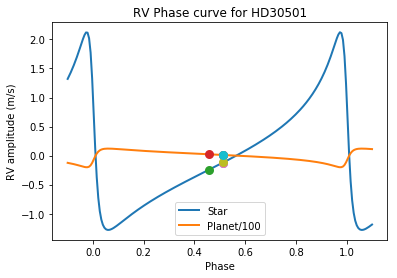

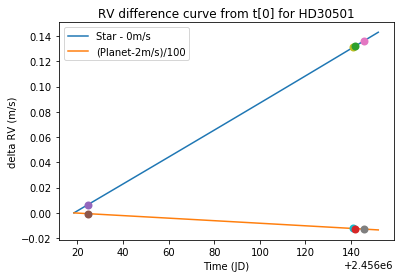


Target HD162020
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-1.25828313 -1.25152543] m/s
RV change over exptime     = [ 0.00542135  0.00556971] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 53.83294444444444 
Gamma subtracted rv values = [ 67.73708571  67.37329875] m/s
RV change over exptime     = [-0.29184697 -0.29983377] m/s
Successive Star RV Diff - star     = [ 0.0067577] m/s
Successive planet RV Diff - planet = [-0.36378696] m/s
Band Lower wl shift - star         = [  4.78116817e-08] nm
Band Upper wl shift - star         = [  4.86938916e-08] nm
Band Lower wl shift - planet       = [  2.57382226e-06] nm
Band Upper wl shift - planet       = [  2.62132835e-06] nm


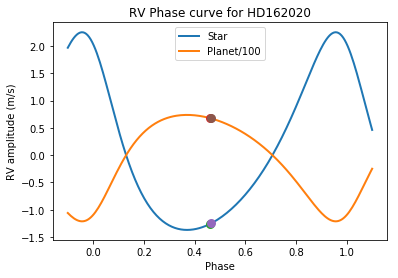

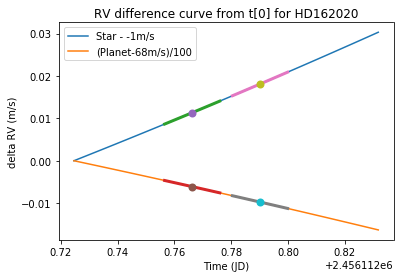


Target HD202206
Radial velocity values of the host star.
Gamma subtracted RV values for b = [ 0.14140583  0.14663501  0.13615936] m/s
RV change over exptime for b     = [ 0.00010818  0.00010606  0.0001103 ] m/s
Gamma subtracted RV values for c = [ 0.04256456  0.04256187  0.042566  ] m/s
RV change over exptime for c     = [ -4.24631995e-08  -6.74541361e-08  -1.77066258e-08] m/s
Combined RV value for triplet    = [ 0.18397038  0.18919688  0.17872536] m/s
Combined RV Diff between Obs     = [ 0.0052265  -0.01047152] m/s

Radial velocity values of the planet.
Maximum mass ratio value for b   = 11.639555555555555 
Maximum mass ratio value for c   = 60.86382122905028 
Gamma subtracted RV values for b = [-1.64590096 -1.70676632 -1.58483439] m/s
RV change over exptime for b     = [-0.00125911 -0.00123448 -0.00128388] m/s
Gamma subtracted RV values for c = [-2.59064167 -2.59047833 -2.59072966] m/s
RV change over exptime for c     = [  2.58447258e-06   4.10551648e-06   1.07769291e-06] m/s
Combin

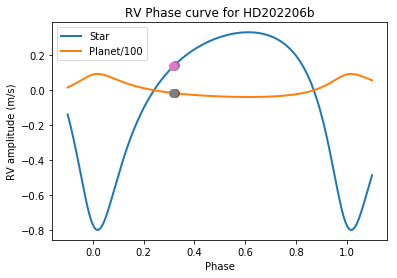

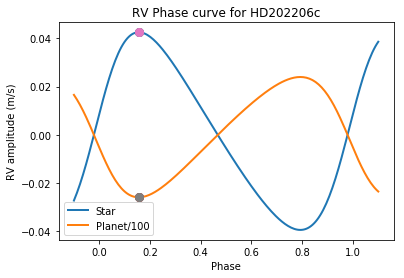

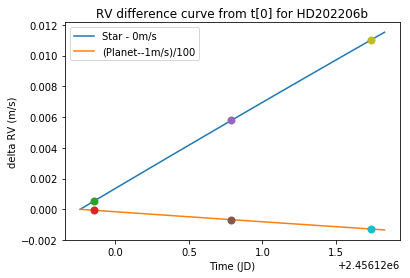

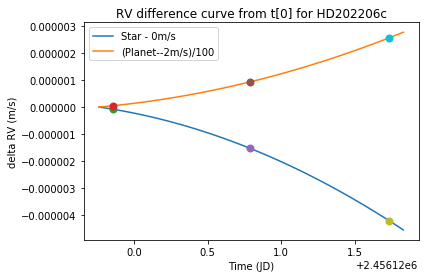


Target HD211847
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-0.00429918 -0.00634782] m/s
RV change over exptime     = [ -5.64109538e-06  -5.76618746e-06] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 6.352944516129032 
Gamma subtracted rv values = [ 0.02731242  0.04032732] m/s
RV change over exptime     = [  3.58375660e-05   3.66322690e-05] m/s
Successive Star RV Diff - star     = [-0.00204864] m/s
Successive planet RV Diff - planet = [ 0.0130149] m/s
Band Lower wl shift - star         = [  1.44941623e-08] nm
Band Upper wl shift - star         = [  1.47615538e-08] nm
Band Lower wl shift - planet       = [  9.20817911e-08] nm
Band Upper wl shift - planet       = [  9.37807272e-08] nm


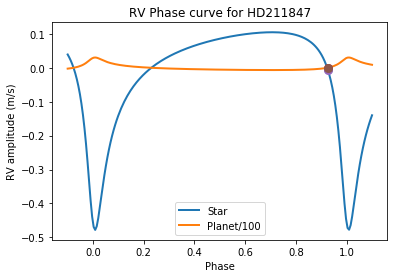

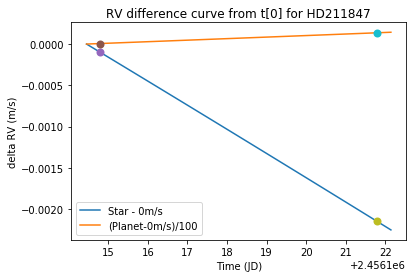


Target HD4747
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [ 0.32204644] m/s
RV change over exptime     = [ -5.43382074e-05] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 18.406151843817785 
Gamma subtracted rv values = [-5.92763567] m/s
RV change over exptime     = [ 0.00100016] m/s
Successive Star RV Diff - star     = [] m/s
Successive planet RV Diff - planet = [] m/s
Band Lower wl shift - star         = [] nm
Band Upper wl shift - star         = [] nm
Band Lower wl shift - planet       = [] nm
Band Upper wl shift - planet       = [] nm


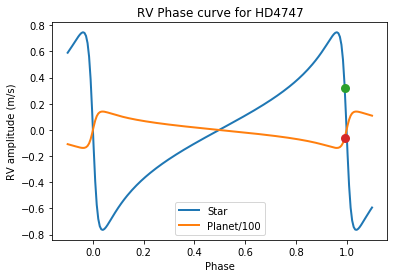

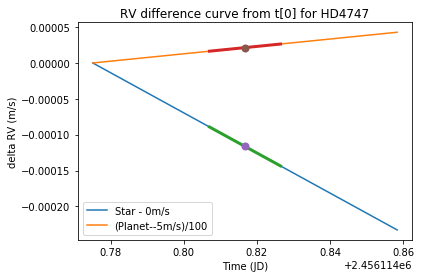


Target HD167665
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-0.73764314 -0.73765154 -0.74016865] m/s
RV change over exptime     = [ -6.42980278e-06  -6.42838797e-06  -5.98099866e-06] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 23.601154150197623 
Gamma subtracted rv values = [ 17.40922954  17.40942767  17.46883449] m/s
RV change over exptime     = [ 0.00015175  0.00015172  0.00014116] m/s
Successive Star RV Diff - star     = [ -8.39492920e-06  -2.51711494e-03] m/s
Successive planet RV Diff - planet = [ 0.00019813  0.05940682] m/s
Band Lower wl shift - star         = [  5.95719030e-11   1.78088158e-08] nm
Band Upper wl shift - star         = [  6.04813977e-11   1.81375981e-08] nm
Band Lower wl shift - planet       = [  1.40198608e-09   4.20307970e-07] nm
Band Upper wl shift - planet       = [  1.42745193e-09   4.28065505e-07] nm


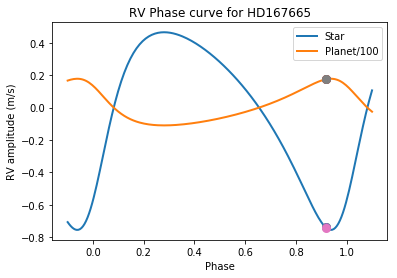

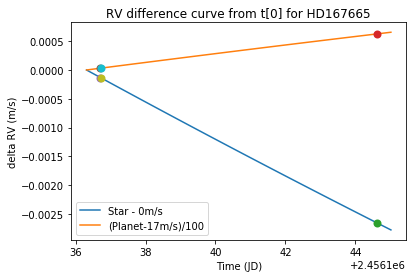


Target HD168443
Radial velocity values of the host star.
Gamma subtracted RV values for b = [-0.15999288 -0.15881751] m/s
RV change over exptime for b     = [ 0.00112504  0.0011211 ] m/s
Gamma subtracted RV values for c = [ 0.30622082  0.30621021] m/s
RV change over exptime for c     = [ -1.01349347e-05  -1.01380672e-05] m/s
Combined RV value for triplet    = [ 0.14622794  0.14739271] m/s
Combined RV Diff between Obs     = [ 0.00116476] m/s

Radial velocity values of the planet.
Maximum mass ratio value for b   = 136.09116072594333 
Maximum mass ratio value for c   = 60.62480079101959 
Gamma subtracted RV values for b = [ 21.77361661  21.61365888] m/s
RV change over exptime for b     = [-0.15310862 -0.15257143] m/s
Gamma subtracted RV values for c = [-18.56457632 -18.56393318] m/s
RV change over exptime for c     = [ 0.00061443  0.00061462] m/s
Combined RV value for triplet    = [ 3.20904029  3.04972571] m/s
Combined RV Diff between Obs     = [-0.15931459] m/s
Successive Star RV Diff 

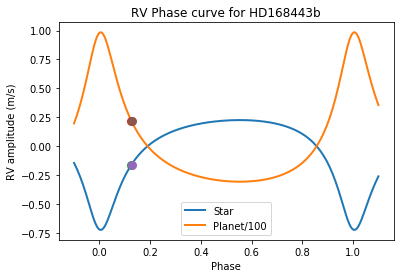

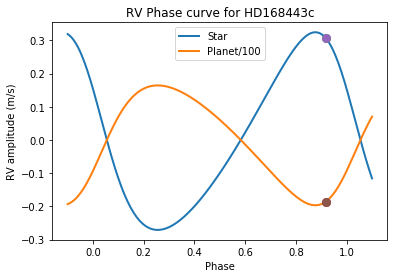

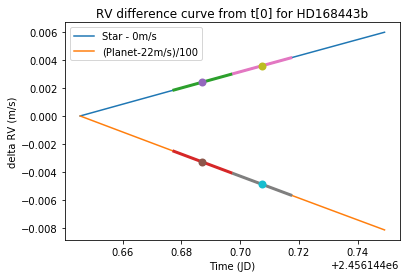

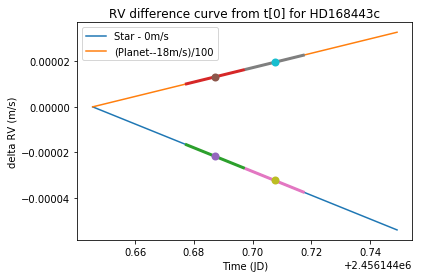

In [7]:
print("For ploting the RV curves the Planet RV has been divided by a factor of 100.")
print("When zooming up to just during the observations. The values are the difference from the RV at the start of this time space. To show the relative diferences, The planet RV is again scaled down by a factor of 100.")
print("The tick lines visible in a couple of the plots show the RV change during observation nod cycle. Only visible when observations were very close.")

results = RV_calculations(times_dict, params_dict)


From testing it appears that all the calculations for the planet RV, expected doppler shifts, RV difference between observations are all just scaled by the planet to star mass ratio m1/m2.

When only a minimum planet mass is given (m2sinI) then this corresponds to a maxmium of the mass ratio and therefore this will be a maximum expected doppler shift.



In [7]:
# Print out table for RV of the planet

print("Name: \t\t RV 1 \t\t RV 2 \t\t RV 3 \t\t RV 4")
for targ in results.keys():
    vals = list(np.round(results[targ], 3))
    #print(vals)
    for i in range(4-len(vals)):
        vals.append([])
    
    print("{0}  \t{1} \t{2} \t {3} \t{4}\t ".format(targ, vals[0],vals[1],vals[2],vals[3]))
    
print("\nMaximum RV difference between all obervations of each target")
print("\nName: \t Delta RV(m/s) \t| msini(MJ) K2 Semi-Amp(m/s)  Period (days)")
Msun_Mjup = 1047.56 # Mjup
for targ in results.keys():
    vals = list(np.round(results[targ], 3))
    #print(vals)
    for i in range(4-len(vals)):
        vals.append([])
    targ_params = params_dict[targ]
    
    K2 = -targ_params[1] * Msun_Mjup * targ_params[6] / targ_params[7]
    Period  = targ_params[5]
    print("{0}  \t{1} \t|\t{2} \t{3}\t\t{4}".format(targ, int(max(vals)-min(vals)), int(targ_params[7]), int(K2), int(Period)))
    

Name: 		 RV 1 		 RV 2 		 RV 3 		 RV 4
HD211847  	27.312 	40.327 	 [] 	[]	 
HD167665  	17409.23 	17409.428 	 17468.834 	[]	 
HD202206b  	989.388 	1208.668 	 781.56 	[]	 
HD168443b  	-28770.456 	-28783.262 	 [] 	[]	 
HD4747  	8878.679 	[] 	 [] 	[]	 
HD162020  	67737.086 	67373.299 	 [] 	[]	 
HD202206c  	-1218.856 	-1226.095 	 -1211.734 	[]	 
HD168443c  	-15547.232 	-15548.039 	 [] 	[]	 
HD30501  	2327.667 	1152.779 	 1142.773 	1101.477	 

Maximum RV difference between all obervations of each target

Name: 	 Delta RV(m/s) 	| msini(MJ) K2 Semi-Amp(m/s)  Period (days)
HD211847  	13 	|	155 	-1851		7929
HD167665  	59 	|	50 	-14384		4451
HD202206b  	427 	|	93 	-6615		255
HD168443b  	12 	|	7 	-64661		58
HD4747  	0 	|	46 	-13902		13835
HD162020  	363 	|	14 	-97599		8
HD202206c  	14 	|	17 	-2692		1383
HD168443c  	0 	|	17 	-18048		1749
HD30501  	1226 	|	90 	-16056		2073


### Test for planet RV (old)
Need to determine how to calculate the expected RV of the planet (not the star) to be able to get proper values out of this. If the planet RV is > 100m/s it would be good for visible detections i think.


In [8]:
## Calcualte K of planet

def RV_planet_old(time, star_params, masses, only_minimum=False, use_offset=True):
    """ Calcualte RV value for a planet instead of star
    
    Need to change the K value"""
    star_mass = masses[0]
    planet_mass = masses[1]
    
    planet_params = star_params[:]
    
    planet_params[1] = -(star_mass/planet_mass) * planet_params[1] 
    #planet_params[2] = planet_params[2] + 180    # phase offset
    
    planet_rv = RV_from_params(time, planet_params, use_offset=use_offset)
    
    return planet_rv


In [9]:
target = "HD30501"       

print("Mass ratio ", HD30501_mass[0]/HD30501_mass[1])
star_rv = RV_from_params(HD30501_times, HD30501_params, use_offset=False)

planet_rv = RV_planet(HD30501_times, HD30501_params, HD30501_mass, use_offset=False)

print("star_rv   ", star_rv)
print("planet_rv ", planet_rv)




Mass ratio  0.009000000000000001


NameError: name 'RV_planet' is not defined

In [ ]:
# Need to test how the shift changes when only have the minimum mass for planet. 

In [ ]:
# Effect of I on MsinI

I = np.linspace(0.2,np.pi/2,100)[::-1]
MsinI = 50

M = MsinI/np.sin(I)

plt.figure()
plt.plot(I*180/np.pi, M)
plt.title("Mass verse Inclination, msinI=50 Mjup")
plt.ylabel("Planet Mass (MJup)")
plt.show()

In [ ]:
#Effect of msinI instead of M in K determination
K1 = 500   # m/s
m1 = 1000   # MJ
m2sinI = 50 # MJ
m2 = m2sinI/np.sin(I)  # MJ
K2 = K1 * -m1/m2

plt.figure()
plt.plot(I*180/np.pi, K2)
plt.xlabel("Inclination I (deg)")
plt.ylabel("Planet RV amplitude K2")
plt.title("Inclination on Planet RV Semi-Amplitude K2")
plt.show()

#K2 for planet is maximum at minimum mass

# GIANO OPTICON Proposal
Trying to add future events to see where they fall on the graphs

[2456144.68718, 2456144.70753]


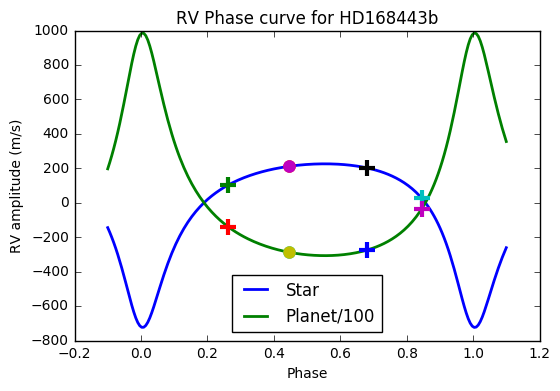

[2456144.68718, 2456144.70753]


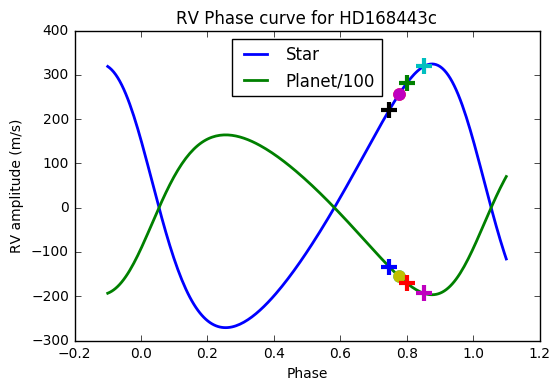

[2456120.78801, 2456121.73727, 2456119.85411]


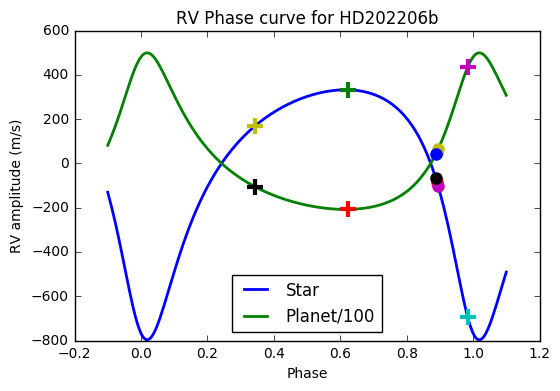

[2456120.78801, 2456121.73727, 2456119.85411]


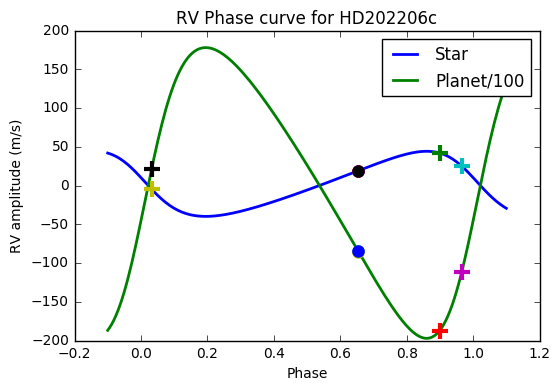

[2456114.81674]


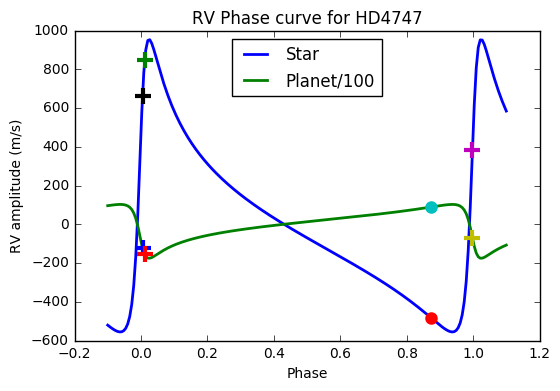

[2456136.70895, 2456136.73434, 2456144.62087]


In [10]:
# Investigating adding an observation at 2017-7-01
# For GIANO OPTICON Proposal
# Calcualted best targets using astroplan
select_targets = ["HD168443b","HD168443c", "HD202206b", "HD202206c", "HD4747", "HD167665"] 
#The Julian date for CE  2017 July  1 00:00:00.0 UT is
#JD 2457935.500000

new_times = [2457843.50, 2457935.50, 2458027.50]

for targ in select_targets:
    #for T in new_times:
        # T = [T]
        T = new_times
        target = targ
        #print("Date of Observation = {}".format(T))
        target_time = times_dict[target[:8]]
        print(target_time)

        target_param = params_dict[target]
        plot_RV_phase_curve(target_param, name=target, t_vals=target_time, use_offset=False, t_future=T)
            


Target HD168443
Radial velocity values of the host star.
Gamma subtracted RV values for b = [ 211.40576895  211.49986415  202.4783278   102.63575172   25.25639986] m/s
RV change over exptime for b     = [ 0.09006337  0.0897528  -0.13724045  0.35339403 -0.74971905] m/s
Gamma subtracted RV values for c = [ 256.45003189  256.46333491  221.15134801  281.5528412   319.69100489] m/s
RV change over exptime for c     = [ 0.01271141  0.01271071  0.01407346  0.01100418  0.00439025] m/s
Combined RV value for triplet    = [ 467.85580083  467.96319906  423.62967582  384.18859292  344.94740475] m/s
Combined RV Diff between Obs     = [  0.10739823 -44.33352324 -39.44108289 -39.24118818] m/s

Radial velocity values of the planet.
Maximum mass ratio value for b   = 136.09116072594333 
Maximum mass ratio value for c   = 60.62480079101959 
Gamma subtracted RV values for b = [-28770.45648003 -28783.26200495 -27555.51065259 -13967.81858423
  -3437.17277242] m/s
RV change over exptime for b     = [ -12.256

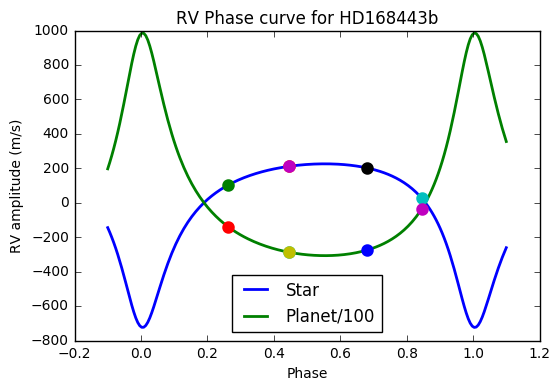

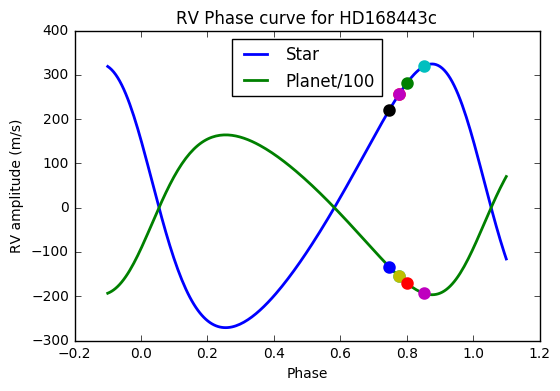

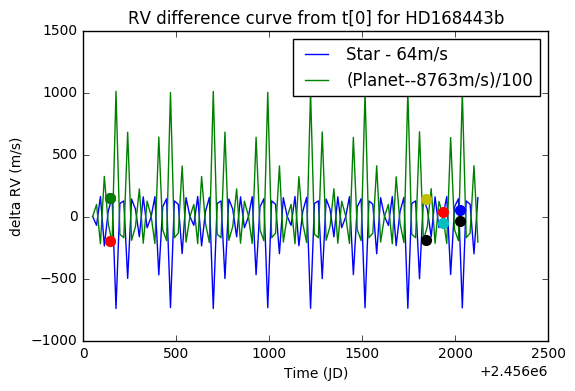

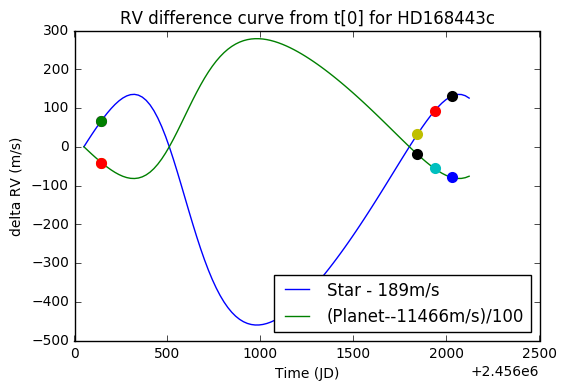


Target HD4747
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-482.37561322  383.84659626  661.60610289  847.99429699] m/s
RV change over exptime     = [-0.00203258  0.06397062  0.05058842  0.02807098] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 18.406151843817785 
Gamma subtracted rv values = [  8878.67878266  -7065.13873541 -12177.62239061 -15608.31179308] m/s
RV change over exptime     = [ 0.037412   -1.17745297 -0.93113812 -0.51667879] m/s
Successive Star RV Diff - star     = [ 866.22220947  277.75950664  186.3881941 ] m/s
Successive planet RV Diff - planet = [-15943.81751807  -5112.4836552   -3430.68940247] m/s
Band Lower wl shift - star         = [ 0.00612859  0.00196517  0.00131871] nm
Band Upper wl shift - star         = [ 0.00624171  0.00200144  0.00134305] nm
Band Lower wl shift - planet       = [ 0.1128038   0.03617124  0.02427241] nm
Band Upper wl shift - planet       = [ 0.11488586  0.03683886  0.02472041] n

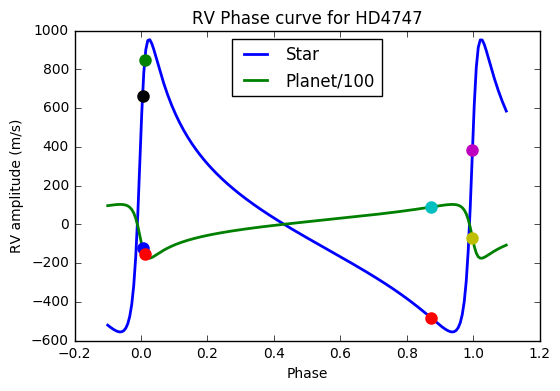

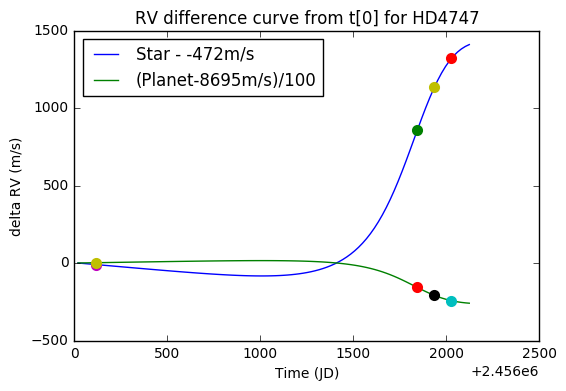


Target HD167665
Radial velocity values of the host star only currently.
Gamma subtracted rv values = [-737.64314434 -737.65153927 -740.16865421  462.55692922  456.06213361
  445.89248582] m/s
RV change over exptime     = [-0.0064298  -0.00642839 -0.005981   -0.00094392 -0.00178    -0.00250207] m/s
Radial velocity values of the Planet.
Maximum mass ratio value   = 23.601154150197623 
Gamma subtracted rv values = [ 17409.22955732  17409.42768734  17468.83450509 -10916.87738984
 -10763.5927173  -10523.57729234] m/s
RV change over exptime     = [ 0.15175077  0.15171737  0.14115847  0.02227772  0.04201008  0.0590518 ] m/s
Successive Star RV Diff - star     = [ -8.39492911e-03  -2.51711494e+00   1.20272558e+03  -6.49479562e+00
  -1.01696478e+01] m/s
Successive planet RV Diff - planet = [  1.98130016e-01   5.94068178e+01  -2.83857119e+04   1.53284673e+02
   2.40015425e+02] m/s
Band Lower wl shift - star         = [  5.93950062e-08   1.78087930e-05   8.50938123e-03   4.59512066e-05
   7.19510

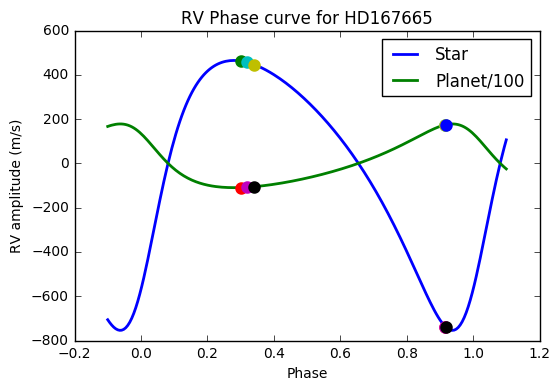

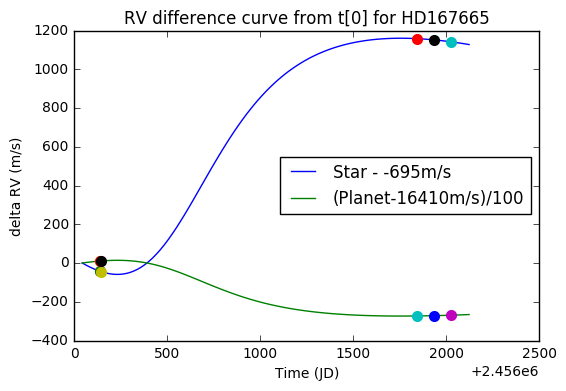


Target HD202206
Radial velocity values of the host star.
Gamma subtracted RV values for b = [ -84.45733491 -103.17581379  -66.71647668  332.07580058 -692.28749136
  168.16142254] m/s
RV change over exptime for b     = [-0.37629449 -0.39060291 -0.36251126 -0.00289869 -0.4305225   0.09653067] m/s
Gamma subtracted RV values for c = [ 19.01906301  19.13201534  18.90792277  41.91985836  24.95488254
  -4.89313182] m/s
RV change over exptime for c     = [ 0.00231386  0.00231352  0.00231417 -0.0017187  -0.00542297 -0.00638166] m/s
Combined RV value for triplet    = [ -65.43827191  -84.04379845  -47.80855392  373.99565894 -667.33260882
  163.26829073] m/s
Combined RV Diff between Obs     = [  -18.60552654    36.23524453   421.80421286 -1041.32826777   830.60089955] m/s

Radial velocity values of the planet.
Maximum mass ratio value for b   = 62.6127816091954 
Maximum mass ratio value for c   = 446.5009836065573 
Gamma subtracted RV values for b = [  5288.10866611   6460.12469636   4177.3041843

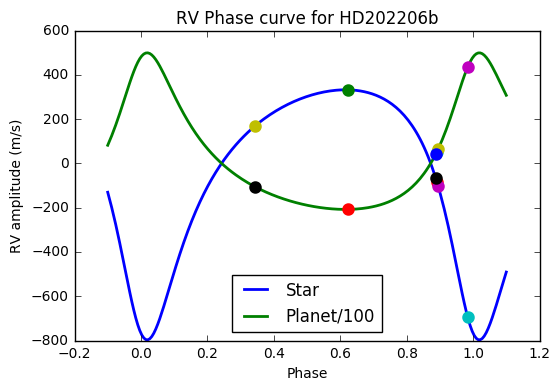

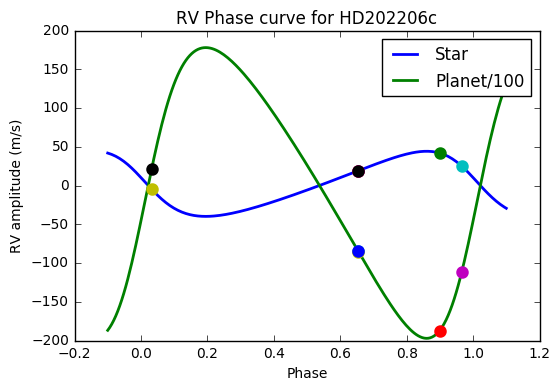

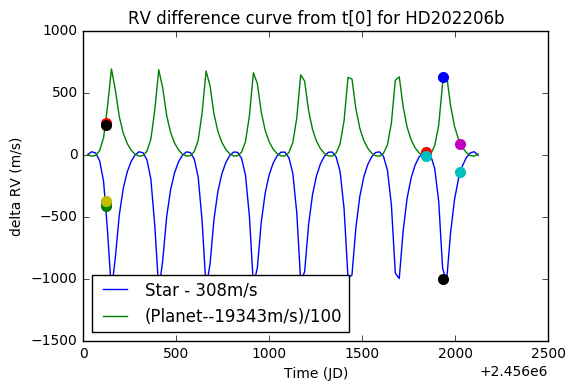

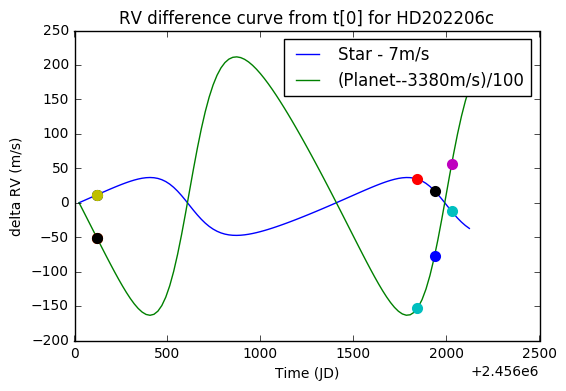

{'HD167665': array([ 17409.22955732,  17409.42768734,  17468.83450509, -10916.87738984,
        -10763.5927173 , -10523.57729234]),
 'HD168443b': array([-28770.45648003, -28783.26200495, -27555.51065259, -13967.81858423,
         -3437.17277242]),
 'HD168443c': array([-15547.23209593, -15548.03858938, -13407.25641791, -17069.08490982,
        -19381.20348614]),
 'HD202206b': array([  5288.10866611,   6460.12469636,   4177.30418439, -20792.18957953,
         43346.04550751, -10529.05442467]),
 'HD202206c': array([ -8492.03033924,  -8542.46366947,  -8442.40611348, -18717.25799156,
        -11142.37959949,   2184.78816851]),
 'HD4747': array([  8878.67878266,  -7065.13873541, -12177.62239061, -15608.31179308])}

In [11]:
# future times
select_targets = ["HD168443b","HD168443c", "HD202206b", "HD202206c", "HD4747", "HD167665"] 

#The Julian date for CE  2017 July  1 00:00:00.0 UT is
#JD 2457935.500000

new_times = [2457843.50, 2457935.50, 2458027.50]

new_HD4747_times = [2456114.81674] + new_times
#print(new)
new_HD202206_times = [ 2456120.78801, 2456121.73727, 2456119.85411] + new_times
new_HD167665_times = [2456136.70895, 2456136.73434, 2456144.62087] + new_times
new_HD168443_times = [2456144.68718, 2456144.70753] + new_times

#params_dict = {"HD30501":HD30501_params, "HD211847":HD211847_params, \
#               "HD4747":HD4747_params, "HD167665":HD167665_params, \
#               "HD162020":HD162020_params, \
#               "HD202206b":HD202206b_params,"HD202206c":HD202206c_params, \
#              "HD168443b":HD168443b_params,"HD168443c":HD168443c_params}
               # "HD202206":HD202206_params,
    
new_times_dict = {"HD202206":new_HD202206_times, "HD4747":new_HD4747_times, "HD167665":new_HD167665_times, \
             "HD168443":new_HD168443_times}




RV_calculations(new_times_dict, params_dict)


#### Testing Junk - no need to continue

In [ ]:
test_rv_curves(HD30501_times, HD30501_params)
test_rv_curves(HD162020_times, HD162020_params)
test_rv_curves(HD202206_times, HD202206b_params)
test_rv_curves(HD202206_times, HD202206c_params)
test_rv_curves(HD211847_times, HD211847_params)
test_rv_curves(HD4747_times, HD4747_params)
test_rv_curves(HD167665_times, HD167665_params)
test_rv_curves(HD168443_times, HD168443b_params)
test_rv_curves(HD168443_times, HD168443c_params)


In [ ]:
#%timeit aj_rv = pl_rv_array(HD30501_times, *HD30501_params) # *unpacks parameters from list
    
#%timeit py_rv = rv_curve_py(HD30501_times, *HD30501_params) # ajplanet version is 15 X faster 

In [ ]:
# Test RV determination 

# Get parameters for star and taget
Red_JD = 2400000
#hd30501
mean_val = 0 # 23.710 # +- 0.017
Period = 2073.6   # +3 - 2.9 days
e = 0.741         # +_ 0.04
K1 = 1703.1       #+- 26  ms^-1
Tau = 53851.5      # +- 3 JD    Note: I think this is tau but I am not sure. 
omega = 70.4 * np.pi/180.     # +- 0.7 deg
values = np.empty_like([1,1,1,1])

for i, ti in enumerate(np.array([2456024.505902, 2456140.887153, 2456141.866329, 2456145.904258]) - Red_JD):
    # Calculate Mean anomaly:
    M_anomaly = meananomaly(ti, Tau, Period)

    # Determine true anomaly from mean anomaly
    true_anomaly = trueanomaly(M_anomaly, e)

    # Now Calculalte the RV of Star
    RV = mean_val + K1 *(np.cos(true_anomaly + omega) + e * np.cos(omega))
    

    print("RV value {0} ms^-1 at time {1} JD*".format( RV ,  ti ))
    values[i] = RV
print(values)
print("Difference in RV between observations ", np.diff(values), " m/s,   --- These values don't match with above")  